# Análise do Dataset Scielo

## Imports

In [75]:
%load_ext autoreload
%autoreload 2

import os
from multiprocessing import Pool

from tqdm.notebook import tqdm
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from funcoes import limpa_html
from nlp_funcoes import token_lemma, add_bigram, create_dictionary, create_corpus, ModelLDA, calc_coherence, stop

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Leitura do dataset

In [2]:
# muda o diretório atual para a pasta code onde temos o dataset salvo
os.chdir("../code")
os.getcwd()

'D:\\OneDrive\\monografia\\code'

In [83]:
df = pd.read_feather('scielo_dataset.feather')

In [84]:
seçoes = ['didactic resources', 'articles', 'physics education research']

In [87]:
df = df.query('ano > 2014 & seção not in @seçoes')

## Limpeza do dataset

In [89]:
with Pool() as pool:
    textos = list(tqdm(pool.imap(limpa_html, df['text_html']), total=len(df)))

  0%|          | 0/793 [00:00<?, ?it/s]

## Análise dos Dados

### Tokenize and Lemma

In [90]:
with Pool(10) as pool:
    documentos = list(tqdm(pool.imap(token_lemma, textos), total=len(textos)))

  0%|          | 0/793 [00:00<?, ?it/s]

### Bigram, dicionário e corpus

In [91]:
add_bigram(documentos, min_count=5)
dicionario = create_dictionary(documentos, no_below=10, no_above=0.8)
corpus = create_corpus(dicionario, documentos)

## Modelo LDA

In [92]:
lda = ModelLDA(corpus, dicionario)

### GridSearch no número de tópicos

In [93]:
n_topicos = list(range(10, 21))
with Pool(processes=9) as pool:
    modelos = list(tqdm(pool.imap(lda.run, n_topicos), total=len(n_topicos)))

  0%|          | 0/11 [00:00<?, ?it/s]

In [94]:
coerencias = {'u_mass': [],
              'c_v': [],
              'c_uci': [],
              'c_npmi': []}

for modelo in tqdm(modelos):
    for coe in tqdm(coerencias.keys(), leave=False):
        coerencias[coe].append(calc_coherence(modelo, documentos, dicionario, corpus, coe))

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

### Gráfico das coerências

In [95]:
def plot_coerencias(coerencias):
    fig, ax = plt.subplots(nrows=1, ncols=len(coerencias),
                           figsize=(5*len(coerencias), 5))

    for i, k in enumerate(coerencias):
        y = coerencias[k]

        ax[i].set_title(k)
        ax[i].set_xlabel('Número de tópicos')

        ax[i].scatter(n_topicos, y, s=16, c='black')
        ax[i].plot(n_topicos, y, c='black', ls='--')

    fig.tight_layout()
    plt.show()

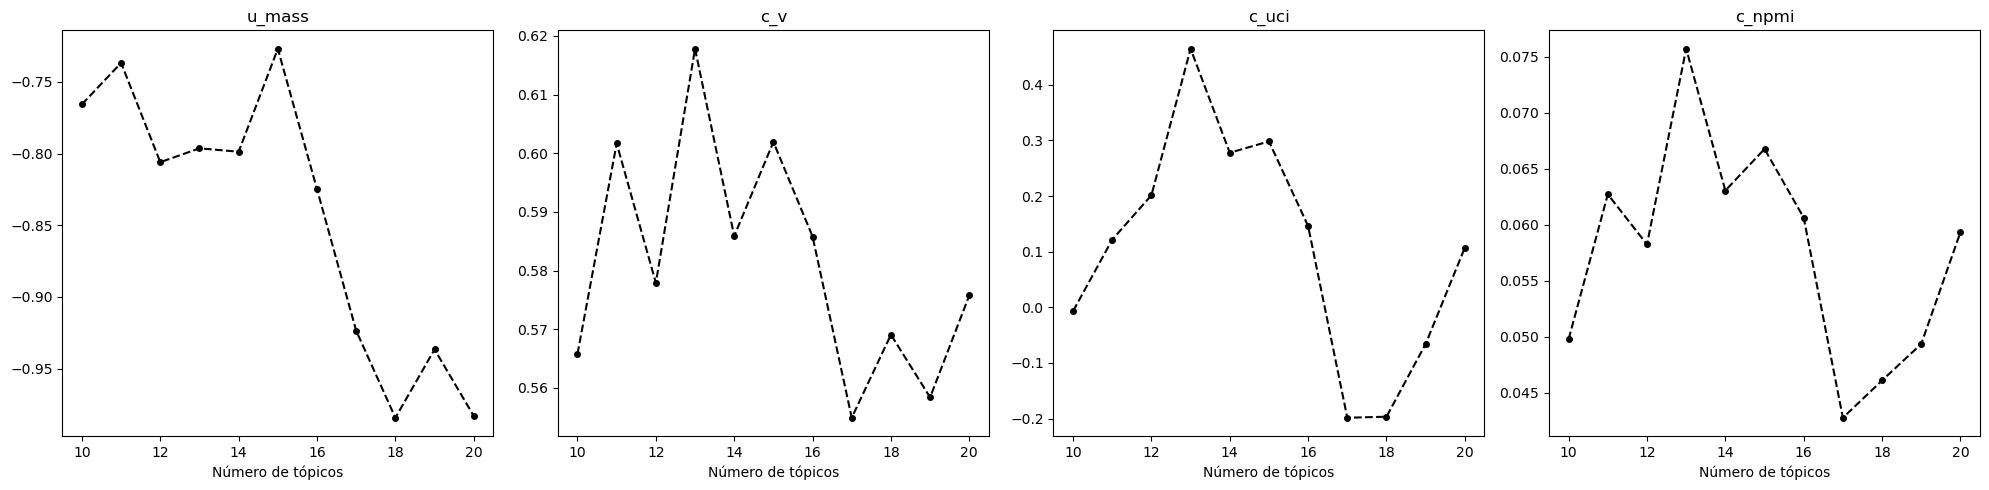

In [96]:
plot_coerencias(coerencias)

### Normalização das coerências 

In [97]:
norm_coerencias = {}
for k, v in coerencias.items():
    x = np.array(v)
    norm_coerencias[k] = (x - min(x)) / (max(x) - min(x))

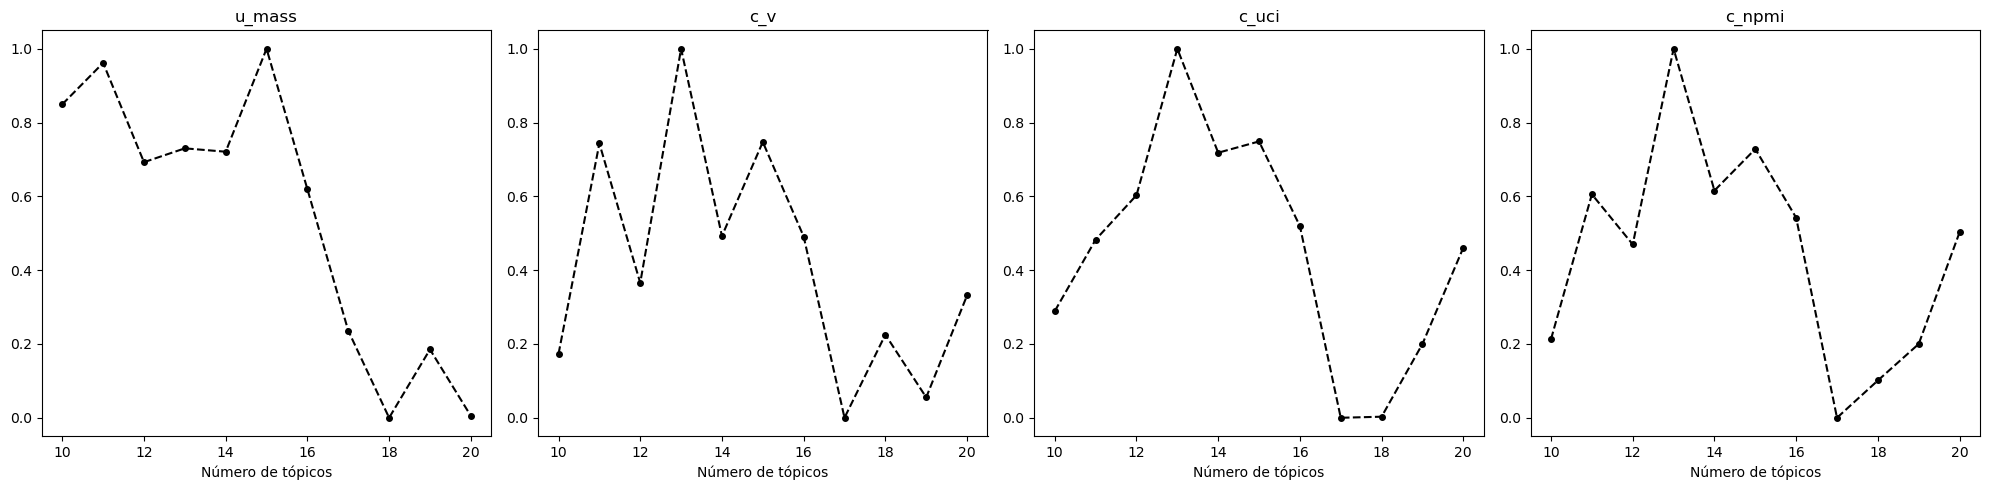

In [98]:
plot_coerencias(norm_coerencias)

In [99]:
medias = sum(norm_coerencias.values()) / len(norm_coerencias)

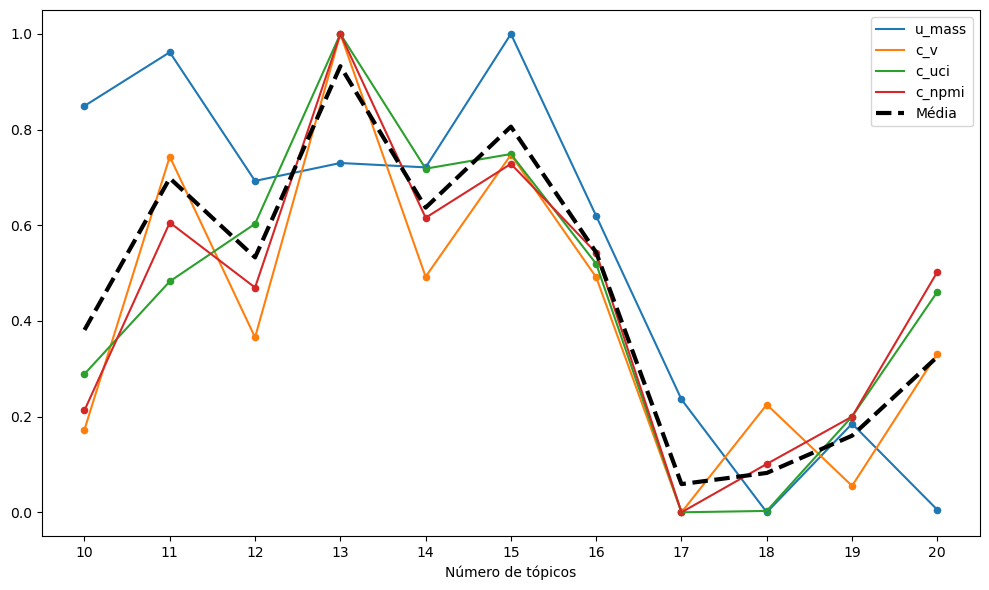

In [100]:
fig, ax = plt.subplots(figsize=(10, 6))

ax.set_xlabel('Número de tópicos')

for i, k in enumerate(norm_coerencias):
    y = norm_coerencias[k]
    ax.scatter(n_topicos, y, s=20)
    ax.plot(n_topicos, y, label=k)

ax.plot(n_topicos, medias, label='Média', c='k', lw=3, ls='--')

ax.set_xticks(n_topicos)
ax.legend()
fig.tight_layout()
plt.show()

In [101]:
for i in medias.argsort()[::-1]:
    print(f'{str(n_topicos[i]).rjust(2, "0")} tópicos | {medias[i]:.2f}')

13 tópicos | 0.93
15 tópicos | 0.81
11 tópicos | 0.70
14 tópicos | 0.64
16 tópicos | 0.54
12 tópicos | 0.53
10 tópicos | 0.38
20 tópicos | 0.33
19 tópicos | 0.16
18 tópicos | 0.08
17 tópicos | 0.06


### Número de tópicos = 13

In [102]:
model = lda.run(13)

In [103]:
model.print_topics(num_words=15)

[(0,
  '0.012*"ensino" + 0.011*"ciência" + 0.011*"física" + 0.010*"professor" + 0.008*"científico" + 0.008*"curso" + 0.007*"pesquisa" + 0.007*"aluno" + 0.007*"formação" + 0.006*"ano" + 0.005*"livro" + 0.005*"disciplina" + 0.005*"conhecimento" + 0.005*"conteúdo" + 0.005*"educação"'),
 (1,
  '0.014*"luz" + 0.012*"movimento" + 0.010*"teoria" + 0.010*"corpo" + 0.009*"velocidade" + 0.008*"newton" + 0.008*"força" + 0.007*"buraco" + 0.007*"negro" + 0.006*"cor" + 0.006*"buraco_negro" + 0.006*"princípio" + 0.005*"raio" + 0.005*"fenômeno" + 0.005*"gravitacional"'),
 (2,
  '0.022*"quântico" + 0.015*"teoria" + 0.009*"partícula" + 0.007*"clássico" + 0.006*"mecânico" + 0.006*"espaço" + 0.006*"feynman" + 0.005*"probabilidade" + 0.005*"problema" + 0.005*"operador" + 0.004*"definir" + 0.004*"informação" + 0.004*"entropia" + 0.004*"processo" + 0.004*"estrutura"'),
 (3,
  '0.033*"luz" + 0.012*"imagem" + 0.012*"onda" + 0.011*"radiação" + 0.010*"lente" + 0.010*"feixe" + 0.008*"fóton" + 0.008*"energia" + 0.

In [104]:
df['topico'] = [max(model.get_document_topics(corpu), key=lambda x: x[1])[0] for corpu in corpus]

In [105]:
df['topico'].value_counts()

12    111
6     104
11     85
2      78
10     70
0      68
7      57
4      52
3      50
1      43
8      37
5      24
9      14
Name: topico, dtype: int64

In [106]:
pd.crosstab(df['seção'], df['topico'])

topico,0,1,2,3,4,5,6,7,8,9,10,11,12
seção,,,,,,,,,,,,,
ano internacional da luz,0,3,1,2,0,0,0,0,0,0,0,0,0
artigos gerais,7,13,38,22,1,4,35,24,19,10,56,56,96
carta ao editor,1,0,0,0,0,1,0,0,0,0,0,0,0
cartas ao editor,7,1,1,1,0,2,0,0,0,0,0,0,0
desenvolvimento em ensino de física,4,1,0,1,4,2,7,0,0,0,2,4,0
errata,1,0,0,0,0,0,0,0,0,0,0,0,1
história da física e ciências afins,9,21,8,2,0,0,2,11,8,1,0,1,3
notas e discussões,1,0,0,0,0,0,1,3,1,0,0,3,6
pesquisa em ensino de física,20,0,2,2,28,14,4,3,0,1,1,3,0
